# Facial Expression Recognition (FER)

This project is the Capstone project for the ML-bookcamp (with Alexey Grigorev).

The dataset come from an old Kaggle competition:
- Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The tried CCN architectures come from variours sources (either papers or githibs):

- CNN architecture 1: https://www.researchgate.net/publication/351056923_Facial_Expression_Recognition_Using_CNN_with_Keras
- CNN architecture 2: https://github.com/gitshanks/fer2013
- CNN architecture 3: https://github.com/amirhossein-hkh/facial-expression-recognition

**Note**: I used these architectures and obviously read some parts of these resources, but I tried to work by myself as much as possible.

Also, I asked Alexey about "Cheating and plagiarism" regarding the CNN architectures from these source here:
- https://datatalks-club.slack.com/archives/C0288NJ5XSA/p1638880791240000


---

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

#### Seed for reproductibility

Does't seem very useful

# 1. Load & explore data <a class="anchor" id="P01"></a>

In [55]:
#colab_path = '/content/drive/MyDrive/Colab_Notebooks/ML_bootcamp/Capstone/'
colab_path = ''

In [56]:
data = pd.read_csv(colab_path+'data/fer2013.csv')

In [57]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Rename the columns <a class="anchor" id="P0_rename_columns"></a>

In [58]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

> This is not very useful in this project, but it's a good habit...

### Check the columns names & types <a class="anchor" id="P0_check_types"></a>

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


> The `target` values are int64
>
> **/!\** The `input` feature is an object and hence it needs to be converted / processed

### Check the ranges of values <a class="anchor" id="P0_check_range"></a>

In [60]:
data.describe() # I usually use includes='all' but its very slow with the pixels arrays

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


### Check the missing values <a class="anchor" id="P0_missing_values"></a>

In [61]:
data.isnull().sum()

emotion    0
pixels     0
usage      0
dtype: int64

> There is no missing values, so we don't need to drop or infer rows

### Check the `usage` feature repartition <a class="anchor" id="P0_check_usage"></a>

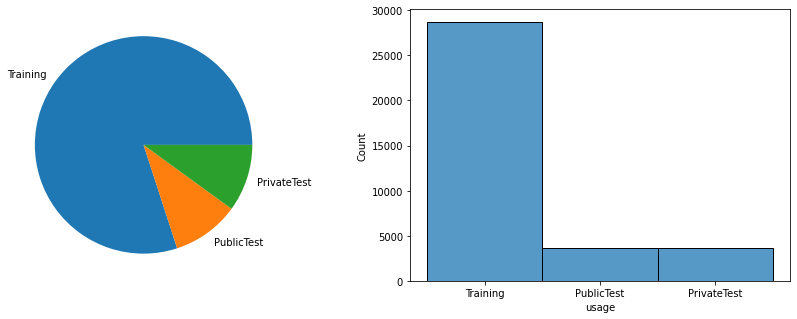

Training       28709
PublicTest      3589
PrivateTest     3589
Name: usage, dtype: int64

In [62]:
fig = plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
check = data['usage'].value_counts()
plt.pie(list(check), labels=check.keys())

plt.subplot(1,2,2)
sns.histplot(data['usage'])

plt.show()
check

In [63]:
total_size = data['usage'].count()
for i, v in enumerate(data['usage'].unique()):
    set_size = data['usage'].value_counts()[i]
    percent = set_size/(total_size/100.0)
    print(f"{v} has {percent:0.2F}% of the total inputs ({set_size}/{total_size})")

Training has 80.00% of the total inputs (28709/35887)
PublicTest has 10.00% of the total inputs (3589/35887)
PrivateTest has 10.00% of the total inputs (3589/35887)


#### First solution:
> The `Training` part can be used as `Training set`
>
> The `PublicTest` part can be used as `Validation set`
>
> The `PrivateTest` part can be used as `Test set`
#### Second solution:
> The 3 sets are merged and then splitted using the sklearn train_test_split function.

### Check the `emotion` target variable <a class="anchor" id="P0_target_variable"></a>

In [64]:
emotion_names = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral',
}

In [65]:
data['emotion'].describe()

count    35887.000000
mean         3.323265
std          1.873819
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: emotion, dtype: float64

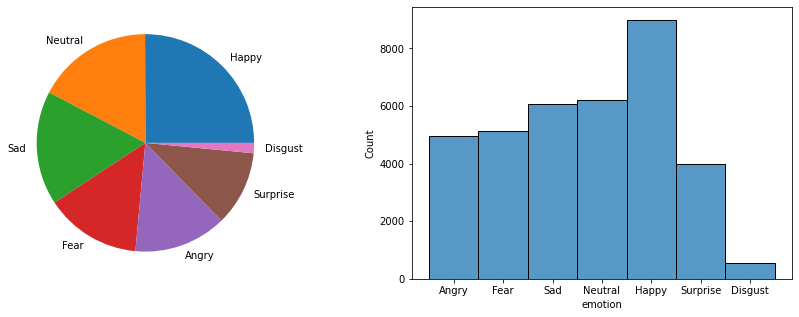

(3) Happy    => 8989
(6) Neutral  => 6198
(4) Sad      => 6077
(2) Fear     => 5121
(0) Angry    => 4953
(5) Surprise => 4002
(1) Disgust  =>  547


In [66]:
fig = plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
check = data['emotion'].value_counts()
plt.pie(list(check), labels=check.keys().map(emotion_names))

plt.subplot(1,2,2)
sns.histplot(data['emotion'].map(emotion_names))

plt.show()

for i, n, v in zip(check.keys(),check.keys().map(emotion_names), check.values):
    print(f"({i}) {n:8} => {v:4}")

> The `Disgust` value seem under-represented. The dataset is clearly imbalanced.
>
> So we will need to use an appropriate solution *(use upsampling and downsampling techniques)* or metric.<br>
> However there is no longtail to consider as the values are restricted to 10
>
> **/!\ Should we remove this expression** in order to improve the result on the other expressions?

In [67]:
data = data[data['emotion'] != 1]

In [68]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [69]:
le = LabelEncoder()
img_labels = le.fit_transform(data['emotion'])
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35340, 6)

### Check the `pixels` input feature <a class="anchor" id="P0_input_feature"></a>

This feature is fullfiled with strings containing grayscale integers.

#### Convert `pixels` input `strings` to `arrays`
/!\ The process takes a lot of ressources, it may slow down your computer.

In [70]:
img_array = data['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

#### Display some images

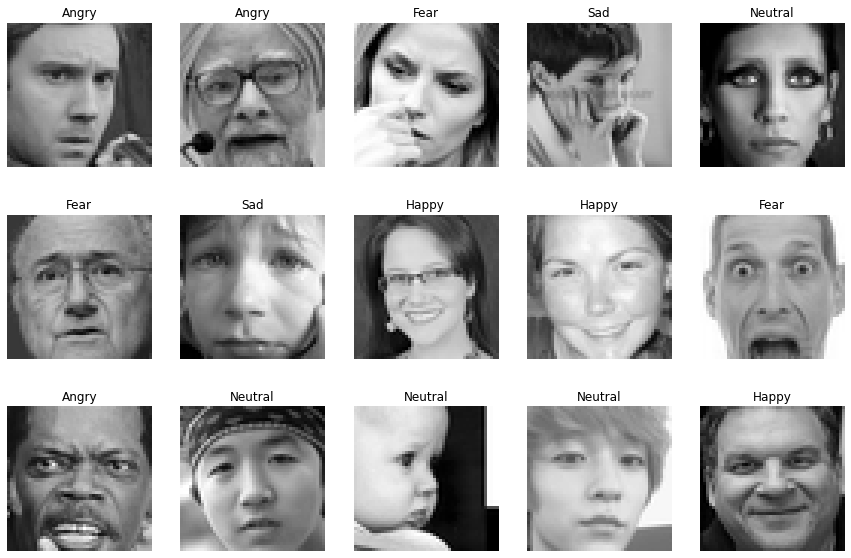

In [71]:
fig = plt.figure(figsize=(15,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(img_array[i], cmap='gray', vmin=0, vmax=255)
    plt.title(emotion_names[data['emotion'][i]])
    plt.axis('off')
    
plt.show()

In [76]:
img_array[0].to

array([[[ 70.],
        [ 80.],
        [ 82.],
        ...,
        [ 52.],
        [ 43.],
        [ 41.]],

       [[ 65.],
        [ 61.],
        [ 58.],
        ...,
        [ 56.],
        [ 52.],
        [ 44.]],

       [[ 50.],
        [ 43.],
        [ 54.],
        ...,
        [ 49.],
        [ 56.],
        [ 47.]],

       ...,

       [[ 91.],
        [ 65.],
        [ 42.],
        ...,
        [ 72.],
        [ 56.],
        [ 43.]],

       [[ 77.],
        [ 82.],
        [ 79.],
        ...,
        [105.],
        [ 70.],
        [ 46.]],

       [[ 77.],
        [ 72.],
        [ 84.],
        ...,
        [106.],
        [109.],
        [ 82.]]], dtype=float32)

# 2. Feature selection <a class="anchor" id="P02"></a>

> On this project, we don't really feature selection...
>
> There is only two input features, `pixels` and `usage`.
> - The `usage` column will be used to split the dataset, then it will be removed.
> - The `pixels` column will be used to train the CNN

# 3. Split the dataset <a class="anchor" id="P03"></a>

As seen above, the `usage` column can be used to split the dataset instead of using the train_test_split function from sklearn.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train_full, X_test, y_train_full, y_test = train_test_split(img_array, img_labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=42)

In [21]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((21204, 48, 48, 1), (7068, 48, 48, 1), (21204, 6), (7068, 6))

In [22]:
assert(X_valid.shape[0] == X_test.shape[0])

In [23]:
assert(img_array.shape[0] == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

In [24]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

img_width, img_height, img_depth, num_classes

(48, 48, 1, 6)

# 4. Prepare generators

In [25]:
from keras.preprocessing.image import ImageDataGenerator

#### Define an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1.

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255) # , preprocessing_function=None
train_datagen

In [27]:
valid_datagen = ImageDataGenerator(rescale=1./255) # , preprocessing_function=None
valid_datagen

#### Define an instance of the ImageDataGenerator that with way more transformations

In [28]:
train_datagen_extra = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
train_datagen_extra

In [29]:
valid_datagen_extra = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
)
valid_datagen_extra

#### Initialize the train & valid generators from the numpy arrays

In [32]:
gen_batch_size=64

In [33]:
train_ds = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=gen_batch_size,
    shuffle=True,
)

In [34]:
valid_ds = valid_datagen.flow( ## train_datagen ?
    x=X_valid,
    y=y_valid,
    batch_size=gen_batch_size,
    shuffle=True,
)

In [35]:
train_ds_extra = train_datagen_extra.flow(
    x=X_train,
    y=y_train,
    batch_size=gen_batch_size,
    shuffle=True,
)

In [36]:
valid_ds_extra = valid_datagen_extra.flow( ## train_datagen ?
    x=X_valid,
    y=y_valid,
    batch_size=gen_batch_size,
    shuffle=True,
)

# 5. Try various *classification* models <a class="anchor" id="P04"></a>

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization

## Convolutional Neural Network - Architecture 1

CNN architecture from: https://www.researchgate.net/publication/351056923_Facial_Expression_Recognition_Using_CNN_with_Keras

In [38]:
def architecture1():
    inputs = keras.Input(shape=(img_width, img_height, img_depth))
    
    # 1st convolution
    C = Conv2D(filters=64, kernel_size=(3,3), padding='same')(inputs)
    B = BatchNormalization()(C)
    A = Activation('relu')(B)
    M = MaxPooling2D((2,2))(A)
    D = Dropout(0.25)(M)
    
    # 2nd convolution
    Con = Conv2D(filters=128, kernel_size=(5,5), padding='same')(D)
    Bat = BatchNormalization()(Con)
    Act = Activation('relu')(Bat)
    Max = MaxPooling2D((2,2))(Act)
    Dro = Dropout(0.25)(Max)
    
    # 3rd convolution
    Con = Conv2D(filters=512, kernel_size=(3,3), padding='same')(Dro)
    Bat = BatchNormalization()(Con)
    Act = Activation('relu')(Bat)
    Max = MaxPooling2D((2,2))(Act)
    Dro = Dropout(0.25)(Max)
    
    # 4rd convolution
    Con = Conv2D(filters=512, kernel_size=(3,3), padding='same')(Dro)
    Bat = BatchNormalization()(Con)
    Act = Activation('relu')(Bat)
    Max = MaxPooling2D((2,2))(Act)
    Dro = Dropout(0.25)(Max)
    
    # Flatten layer
    Fla = Flatten()(Dro)
    
    # 1st fully connected layer
    Den = Dense(256)(Fla)
    Bat = BatchNormalization()(Den)
    Act = Activation('relu')(Bat)
    Dro = Dropout(0.25)(Act)
    
    # 2nd fully connected layer
    Den = Dense(512)(Dro)
    Bat = BatchNormalization()(Den)
    Act = Activation('relu')(Bat)
    Dro = Dropout(0.25)(Act)
    
    # output for up to 7 expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
    outputs = Dense(num_classes, activation='softmax')(Dro)
    
    model = keras.Model(inputs, outputs)
    return model
    

In [39]:
architecture1().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

## Convolutional Neural Network - Architecture 2

CNN architecture from: https://github.com/gitshanks/fer2013

In [40]:
from keras.regularizers import l2

def architecture2():

    num_features = 64
    batch_size = 64

    model = Sequential()
    
    # 1st convolution
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, img_depth), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # 2nd convolution
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # 3rd convolution
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # 4rd convolution
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # Flatten layer
    model.add(Flatten())

    # 1st fully connected layer    
    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.5))

    # output for up to 7 expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
    model.add(Dense(num_classes, activation='softmax'))
    return model
    

In [41]:
architecture2().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 23, 128)       7

## Convolutional Neural Network - Architecture 3

CNN architecture from: https://github.com/amirhossein-hkh/facial-expression-recognition

In [42]:
def architecture3():
  
    model = Sequential()

    # 1st convolution
    model.add(Conv2D(64, (3, 3), input_shape=(img_width, img_height,img_depth)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd convolution
    model.add(Conv2D(128, (3, 3)))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd convolution
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 4rd convolution
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten()) 

    # 1st fully connected layer
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # 2nd fully connected layer
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # output for up to 7 expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
  
    return model

In [43]:
architecture3().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 activation_6 (Activation)   (None, 46, 46, 64)        0         
                                                                 
 batch_normalization_13 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 dropout_13 (Dropout)        (None, 21, 21, 128)      

## Define Optimizer & Loss


In [44]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)

In [45]:
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

In [46]:
from sklearn.metrics import roc_auc_score

In [47]:
def rocauc(yTrue, yPred):
    auc = roc_auc_score(yTrue, yPred)
    return auc[0]

## Compile the model

In [48]:
### model1.compile(optimizer=f_opti, loss=f_loss, metrics=[tf.keras.metrics.CategoricalAccuracy()])

## Fit the models

In [49]:
from tqdm.keras import TqdmCallback

In [50]:
batch_size=64
epochs=100

In [51]:
from keras.callbacks import ModelCheckpoint

In [52]:
def fit_and_save(model, train_ds, valid_ds, name="model1"):

  model.compile(optimizer=f_opti, loss=f_loss, metrics=[tf.keras.metrics.CategoricalAccuracy(), 'accuracy'])

  filepath = colab_path+name+'.epoch{epoch:02d}-categorical_accuracy{val_categorical_accuracy:.2f}.hdf5'

  checkpoint = ModelCheckpoint(filepath=filepath, 
                             #monitor='val_loss',
                             #mode='min'
                             monitor='val_categorical_accuracy',
                             mode='max',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True,
                             )

  history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=100,
    validation_data=valid_ds,
    validation_steps=50,
    callbacks=[TqdmCallback(), checkpoint],
    verbose=1,
  )

  model_json = model1.to_json()
  with open(colab_path+name+".json", "w") as yaml_file:
    yaml_file.write(model_json)

  model1.save(colab_path+name+".h5")

  return history

In [ ]:
model1 = architecture1()
history1 = fit_and_save(model1, train_ds, valid_ds, name="model1")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.9524 - categorical_accuracy: 0.2338 - accuracy: 0.2338
Epoch 00001: val_categorical_accuracy improved from -inf to 0.25094, saving model to model1.epoch01-categorical_accuracy0.25.hdf5
100/100 [==============================] - 112s 1s/step - loss: 1.9524 - categorical_accuracy: 0.2338 - accuracy: 0.2338 - val_loss: 1.8199 - val_categorical_accuracy: 0.2509 - val_accuracy: 0.2509
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.7934 - categorical_accuracy: 0.2882 - accuracy: 0.2882
Epoch 00002: val_categorical_accuracy did not improve from 0.25094
100/100 [==============================] - 115s 1s/step - loss: 1.7934 - categorical_accuracy: 0.2882 - accuracy: 0.2882 - val_loss: 1.8953 - val_categorical_accuracy: 0.1850 - val_accuracy: 0.1850
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.7020 - categorical_accuracy: 0.3303 - accuracy: 0.3303
Epoch 00003: val_catego

Epoch 20/100
100/100 [==============================] - ETA: 0s - loss: 1.0769 - categorical_accuracy: 0.5834 - accuracy: 0.5834
Epoch 00020: val_categorical_accuracy did not improve from 0.54562
100/100 [==============================] - 144s 1s/step - loss: 1.0769 - categorical_accuracy: 0.5834 - accuracy: 0.5834 - val_loss: 1.2347 - val_categorical_accuracy: 0.5347 - val_accuracy: 0.5347
Epoch 21/100
100/100 [==============================] - ETA: 0s - loss: 1.0516 - categorical_accuracy: 0.5950 - accuracy: 0.5950
Epoch 00021: val_categorical_accuracy improved from 0.54562 to 0.56156, saving model to model1.epoch21-categorical_accuracy0.56.hdf5
100/100 [==============================] - 132s 1s/step - loss: 1.0516 - categorical_accuracy: 0.5950 - accuracy: 0.5950 - val_loss: 1.1631 - val_categorical_accuracy: 0.5616 - val_accuracy: 0.5616
Epoch 22/100
100/100 [==============================] - ETA: 0s - loss: 1.0193 - categorical_accuracy: 0.6141 - accuracy: 0.6141
Epoch 00022: val_

Epoch 61/100
100/100 [==============================] - ETA: 0s - loss: 0.5740 - categorical_accuracy: 0.7891 - accuracy: 0.7891
Epoch 00061: val_categorical_accuracy did not improve from 0.61625
100/100 [==============================] - 144s 1s/step - loss: 0.5740 - categorical_accuracy: 0.7891 - accuracy: 0.7891 - val_loss: 1.2006 - val_categorical_accuracy: 0.6037 - val_accuracy: 0.6037
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.5791 - categorical_accuracy: 0.7844 - accuracy: 0.7844
Epoch 00062: val_categorical_accuracy did not improve from 0.61625
100/100 [==============================] - 152s 2s/step - loss: 0.5791 - categorical_accuracy: 0.7844 - accuracy: 0.7844 - val_loss: 1.3538 - val_categorical_accuracy: 0.5800 - val_accuracy: 0.5800
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.5494 - categorical_accuracy: 0.7977 - accuracy: 0.7977
Epoch 00063: val_categorical_accuracy did not improve from 0.61625
100/100 [=======

In [ ]:
model1 = architecture1()
history1extra = fit_and_save(model1, train_ds_extra, valid_ds_extra, name="model1extra")

In [ ]:
model2 = architecture2()
history2 = fit_and_save(model2, train_ds, valid_ds, name="model2")

In [ ]:
model2extra = architecture2()
history2extra = fit_and_save(model2, train_ds, valid_ds, name="model2extra")

In [ ]:
model3 = architecture3()
history3 = fit_and_save(model3, train_ds, valid_ds, name="model3")

In [ ]:
model3 = architecture3()
history3extra = fit_and_save(model3, train_ds_extra, valid_ds_extra, name="model3extra")

## Plot the models' results

In [ ]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [ ]:
summarize_diagnostics(history1)

In [ ]:
summarize_diagnostics(history1extra)

In [ ]:
summarize_diagnostics(history2)

In [ ]:
summarize_diagnostics(history2extra)

In [ ]:
summarize_diagnostics(history3)

In [ ]:
summarize_diagnostics(history3extra)